In [305]:
"""
Heidi Jiang
Hospital Financial Analysis

This program assesses the financial health of hospitals in Massachusetts,
California, and Washington based on these financial ratios:
* Current ratio (liquidity)
* Net profit margin (profitability)
* Debt service coverage ratio (solvency)
"""

'\nHeidi Jiang\nHospital Financial Analysis\n\nThis program assesses the financial health of hospitals in Massachusetts,\nCalifornia, and Washington based on these financial ratios:\n* Current ratio (liquidity)\n* Net profit margin (profitability)\n* Debt service coverage ratio (solvency)\n'

In [306]:
# imports
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [307]:
# constants for K-means clustering
YEAR = 2023
MAX_K = 10
K = 4
FEATURES = ["cr", "npm", "dscr"]

# constants for data
MA_PATH = "data/ma_hospitals.xlsx"
MA_NI = "Total Excess of Revenue Gains and Other Support Over Expenses"
MA_NR = 'Net Patient Service Revenue'
MA_CR = " FINANCIAL METRICS (With COVID-19 Relief Funds)\nCurrent Ratio"
MA_DSCR = " FINANCIAL METRICS (With COVID-19 Relief Funds)\n" \
                "Debt Service Coverage Ratio"

CA_PATH = "data/ca_hospitals.xlsx"
WA_PATH = "data/wa_hospitals.csv"

In [308]:
# read in and process MA hospitals
ma = pd.read_excel(MA_PATH, "Financial Report")
ma = ma[ma["Organization Type"] != "HHS"]
ma["npm"] = ma[MA_NI] / ma[MA_NR]
ma = ma[["Organization Name", MA_CR, "npm", MA_DSCR]].dropna()
ma.columns = ["name", *FEATURES]

In [309]:
def calculate_dscr(df, net_inc, dep_exp, curr_mat, int_exp):
    """
    Parameters:
        df: a DataFrame
        net_inc: net income column name (a string)
        dep_exp: depreciation expense column name (a string)
        curr_mat: current maturities column name (a string)
        int_exp: interest expense column name (a string)
    Returns: a Series
    Does: calculates the debt service coverage ratio based on values 
    in a DataFrame
    """
    df = df.copy()
    # filters out hospitals have no current maturities/interest expense
    df = df[(df[curr_mat] != 0) & (df[int_exp] != 0)]
    dscr = (df[net_inc] + df[dep_exp] + df[int_exp]) / \
        (df[curr_mat] + df[int_exp])
    return dscr

In [310]:
# read in and process CA hospitals
ca = pd.read_excel(CA_PATH)
ca["cr"] = ca["CUR_ASST"] / ca["CUR_LIAB"]
ca["npm"] = ca["NET_INCOME"] / ca["NET_PT_REV"]
ca["dscr"] = calculate_dscr(ca, "NET_INCOME", "EXP_DEPRE", 
                            "CUR_MAT", "EXP_INTRST")
ca = ca[FEATURES].dropna()

In [311]:
# read in and process WA hospitals
wa = pd.read_csv(WA_PATH).query(f"Year == {YEAR}")
wa["cr"] = wa["Total_Current_Assets"] / wa["Total_Current_Liabilities"]
wa["npm"] = wa["Net_Revenue_Or_Expense"] / wa["Net_Patient_Services_Revenue"]
wa["dscr"] = calculate_dscr(wa, "Net_Revenue_Or_Expense", "Depreciation", 
                            "Current_Maturities", "Interest")
wa = wa[FEATURES].dropna()

In [312]:
# merge data from all three states
merged = pd.concat([ma, ca, wa], ignore_index=True)

# get indices for two hospitals with known financial risk
carney_idx = merged[merged["name"] == "Steward Carney Hospital"].index[0]
nashoba_idx = merged[merged["name"] == "Nashoba Valley Medical Center"].index[0]

In [313]:
def iqr_method(series):
    """
    Parameters: a Series
    Returns: a Series
    Does: filters outliers from a Series using the IQR method
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series >= lower) & (series <= upper)]

In [314]:
def normalize_series(series):
    """
    Parameters: a Series
    Returns: a Series
    Does: applies min-max normalization to a Series
    """
    series = series.copy()
    mn = series.min()
    mx = series.max()
    return (series - mn) / (mx - mn)

In [315]:
# store the two test rows (Nashoba and Carney) separately
test_rows = merged.loc[[carney_idx, nashoba_idx]]
merged = merged.drop([carney_idx, nashoba_idx])

In [316]:
# filter for outliers and illogical current ratios
merged = merged[FEATURES]
merged = merged.apply(lambda col : iqr_method(col))
merged = merged[merged["cr"] >= 0]

In [317]:
# add back the test rows and normalize the data
merged = pd.concat([merged, test_rows])
merged = merged[FEATURES].dropna()
final = merged.apply(lambda col : normalize_series(col))

In [ ]:
def kmeans_model(data, k):
    """
    Parameters:
        data: DataFrame
        k: an int
    Returns: a tuple (x, y), where 
            x = an array of K-means labels
            y = an array of K-means inertias
    Does: creates and fits a K-means model, returning the labels and inertias
    """
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    return kmeans.labels_, kmeans.inertia_

In [319]:
# get inertias and silhouette scores for a list of K-values
inertias = []
sil_scores = []
k_vals = list(range(2, MAX_K))
for k in k_vals:
    labels, inertia = kmeans_model(final, k)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(final, labels))

Text(0, 0.5, 'Inertias')

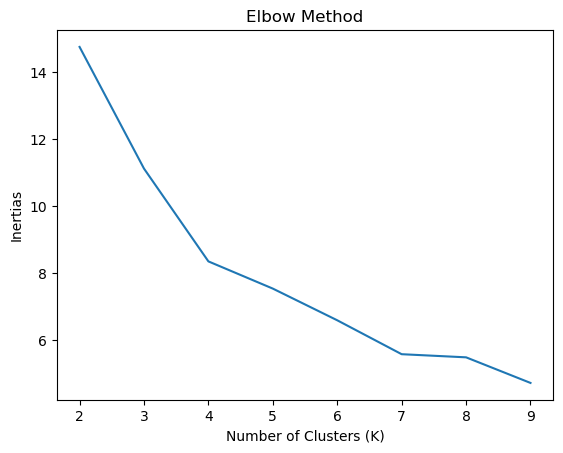

In [320]:
# plot elbow method
plt.plot(k_vals, inertias)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertias")

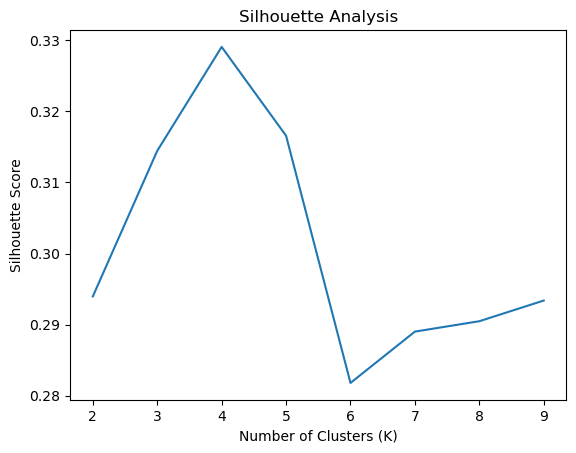

In [321]:
# plot silhouette scores
plt.plot(k_vals, sil_scores)
plt.title("Silhouette Analysis")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

In [322]:
# use the optimal K-value for the model
labels = kmeans_model(final, K)[0]
final["Cluster"] = labels + 1

In [323]:
# print the clusters for Carney and Nashoba
carney_cluster = final.loc[carney_idx]["Cluster"]
nashoba_cluster = final.loc[nashoba_idx]["Cluster"]
print(f"Steward Carney Hospital Cluster: {carney_cluster:.0f}")
print(f"Nashoba Valley Medical Center Cluster: {nashoba_cluster:.0f}")

Steward Carney Hospital Cluster: 1
Nashoba Valley Medical Center Cluster: 2


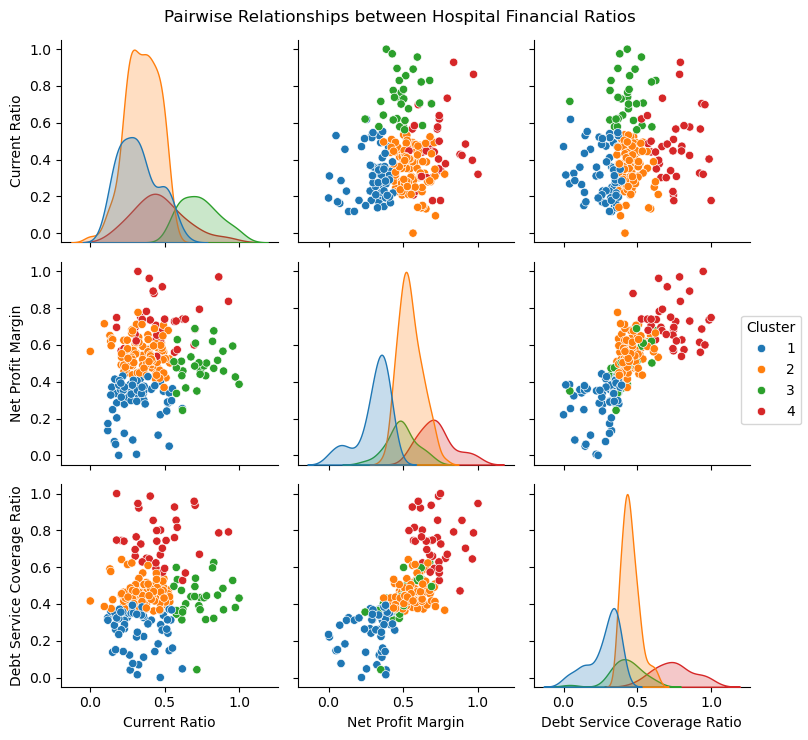

In [324]:
# visualizes the results on pairplots
pairplot = sns.pairplot(final, hue="Cluster", palette="tab10")
pairplot._legend.set_frame_on(True)
pairplot.x_vars = ["Current Ratio", "Net Profit Margin", 
                   "Debt Service Coverage Ratio"]
pairplot.y_vars = ["Current Ratio", "Net Profit Margin", 
                "Debt Service Coverage Ratio"]
pairplot._add_axis_labels()
plt.suptitle("Pairwise Relationships between Hospital Financial Ratios")
plt.tight_layout(rect=[0, 0, 0.95, 1])

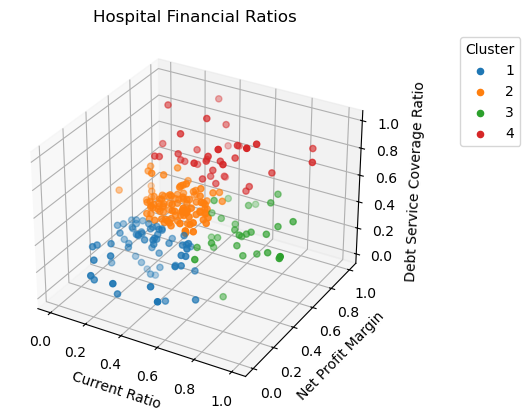

In [326]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i in range(K):
    cluster = final[final["Cluster"] == i + 1]
    ax.scatter(cluster["cr"], cluster["npm"], cluster["dscr"], label=i + 1)
ax.set_xlabel("Current Ratio")
ax.set_ylabel("Net Profit Margin")
ax.set_zlabel("Debt Service Coverage Ratio")
plt.title("Hospital Financial Ratios")
plt.legend(title="Cluster", bbox_to_anchor=(1.4, 1))